In [183]:
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from random import randrange
import networkx as nx
import re
import os


class Graph:
    '''
    Graph class that accpets file path as an argument
    '''
    
    def __init__(self, path):
        # Coordinates of all nodes in the graph
        self._coordinates = self.read_tsp_file(path)
        # List of all nodes 
        self._cities = [*self._coordinates.keys()]
        # Total number of nodes
        self._size = len(self._cities)
        # Distances between each nodes in the graph
        self._distances = self.compute_distances()
        # File index to generate a file name of the plot images
        self._file_index = 0
        
        
    def reset_file_index(self):
        '''
        This method is only needed to reset the index of the file name when generating graphs
        '''
        self._file_index = 0
        return
    

    def read_tsp_file(self, path):
        """"
        Read TSP file
        """
        city_list = []

        with open(path, 'r') as f:
            _data = re.findall(r'\n([0-9].*)', f.read())

        # Split each line by space and convert to float
        for line in _data:
            city_list.append(tuple(map(float, line.split())))
        return { int(vertex): (x,y) for vertex, x, y in city_list }
    
    
    def euclidean_distance(self, cityA, cityB):
        """
        Formula to calculate the Euclidean distance 
        """
        # Math library
        import math
        
        x1 = self._coordinates[cityA][0]
        y1 = self._coordinates[cityA][1]
        x2 = self._coordinates[cityB][0]
        y2 = self._coordinates[cityB][1]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    
    def add(self, i, j, k):
        """
        Add method find the cost of adding node k between node i and node j
        """
        return round(self._distances[i][k] + self._distances[k][j] - self._distances[i][j], 2)

    
    def compute_distances(self):
        """
        Compute distance method invokes at initialization and calculates the cost of each edge in the graph
        """
        self.distances = defaultdict(dict)
        for cityA in self._cities:
            for cityB in self._cities:
                if cityA != cityB and cityB not in self.distances[cityA]:
                    distance = self.euclidean_distance(cityA, cityB)
                    self.distances[cityA][cityB] = round(distance, 2)
                    self.distances[cityB][cityA] = round(distance, 2)   
        return self.distances
    
    
    def closest_neighbor(self, tour, node, in_tour=False):
        """
        Find the closest node which is/is not in the tour, based on the in_tour flag
        """
        neighbors = self._distances[node]
        current_dist = [(c, d) for c, d in neighbors.items()
                        if (c in tour if in_tour else c not in tour)]
        return sorted(current_dist, key=itemgetter(1))[0]


    def total_distance(self, tour):
        """
        Calculate total distance by passing completed tour 
        For example: [1, 2, 3, 4, 1]
        """
        total_distance = 0
        for i in range(1, len(tour)):
            total_distance += graph._distances[tour[i-1]][tour[i]]
        return round(total_distance, 2)
    
    
    def nearest_insertion(self):
        '''
        Returns a tuple with a list of all completed cycles and total weights
        '''
        # Choose ramdom city
        city = randrange(1, self._size)
        # Initiate a list of current tour and all completed tours
        tour, tours = [city], []
        # Find the closest node to the first random node which is not in the tour yet
        neighbor, distance = self.closest_neighbor(tour, city, False)
        # Add second node to the tour
        tour.append(neighbor)
        count = 0
        # Run while loop untill all nodes are visited
        while len(tour) != self._size:
            best, dist = None, float('inf')          
            # Selection step, find node which is not in the tour but the closest to any node 
            # in the tour
            for candidate in self._cities:
                if candidate in tour:
                    continue
                #  Consider only the distances to nodes already in the tour
                _, length = self.closest_neighbor(tour, candidate, True)
                if length < dist:
                    best, dist = candidate, length
            count += 1
            if count == len(self._cities):
                break
            
            # Find an edge (𝑖,𝑗) such that 𝑑𝑖𝑘+𝑑𝑘𝑗−𝑑𝑖𝑗 is minimal     
            index, dist = None, float('inf')
            # Complete the cycle in the tour
            tour = tour + [tour[0]]
            for i in range(len(tour) - 1):
                add = self.add(tour[i], tour[i + 1], best)
                if add < dist:
                    index, dist = i, add
            tour.insert(index + 1, best)
            tours.append(tour)
            # Remove the cycle from the tour and to insert the next closest node
            tour = tour[:-1] 
        print(tours[-1])
        total_cost = self.total_distance(tours[-1])
        return (tours, total_cost)


    def draw_closest_insertion(self, tour, weights=False): 
        '''
        Plot a function 
        '''
        # Create new graph
        G = nx.Graph()
        pos = self._coordinates
        # Image name
        file_name = f'{self._file_index:0{len(str(self._size))}d}'

        # Add edges to the graph
        for i in range(len(tour)-1):
            G.add_edge(tour[i], tour[i+1], weight = self._distances[tour[i]][tour[i+1]])

        # Display weights of each edge
        if weights: 
            # Get weight for each edge 
            labels = nx.get_edge_attributes(G,'weight')
            # Drow weights to each edge
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

        # Add nodes 
        options = {"node_size": 500, "alpha": 0.5}
        nx.draw_networkx_nodes(G, pos, nodelist=list(pos.keys()), node_color="r", **options)

        # Draw in red edges that are not in shortest path
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=G.edges(),
            width=0.5,
            alpha=0.5,
            edge_color="r",
        )

        # Draw lables in the node
        nx.draw_networkx_labels(G,pos, font_size=10)

        # Increase the size of the plots
        fig = plt.gcf()
        fig.set_size_inches(18, 10.5)
        #plt.figure(1,figsize=(50,50))

        plt.axis("off")
        plt.title('Closest Insertion Algorithm')
        plt.savefig(f'graphs/project_3_{file_name}.png')
        plt.show()
        # Generate the file name in ascending order 
        self._file_index += 1

In [201]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random40.tsp')
all_cycles = graph.nearest_insertion()

[32, 19, 3, 21, 23, 17, 7, 24, 1, 30, 15, 39, 40, 10, 8, 16, 11, 18, 38, 29, 20, 6, 25, 13, 31, 33, 4, 35, 26, 5, 9, 27, 22, 14, 2, 12, 37, 34, 36, 28, 32]
CPU times: user 15.1 ms, sys: 1.15 ms, total: 16.3 ms
Wall time: 15.5 ms


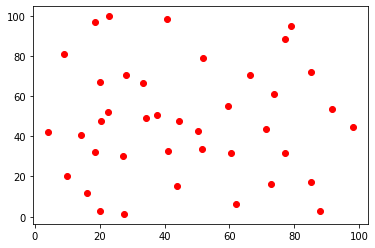

In [202]:
# Plot all nodes in the graph 
import matplotlib.pyplot as plt

x = [coord[0] for coord in graph._coordinates.values()]
y = [coord[1] for coord in graph._coordinates.values()]

plt.scatter(x, y, color='red')
plt.show()

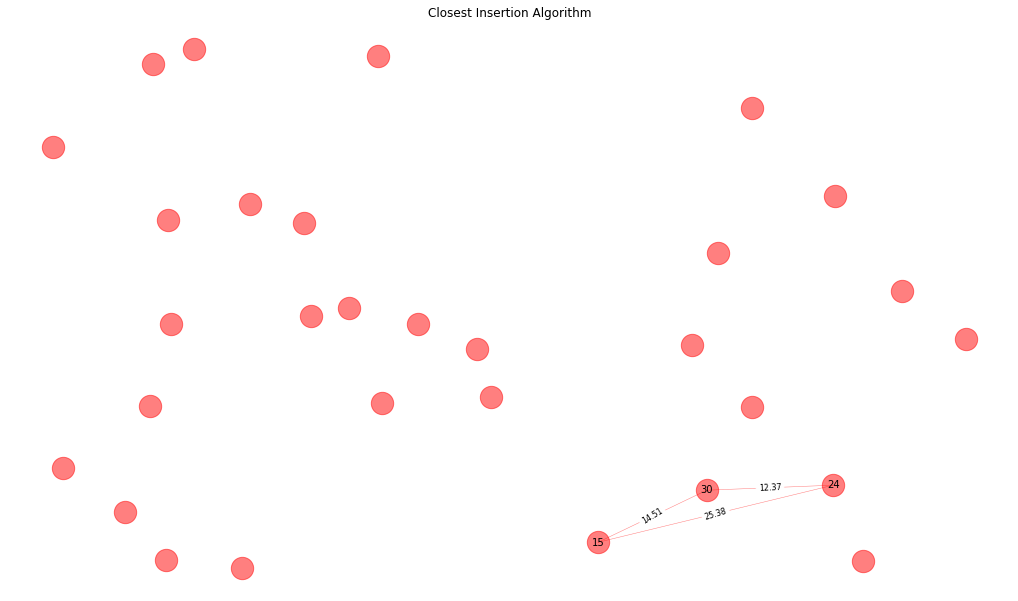

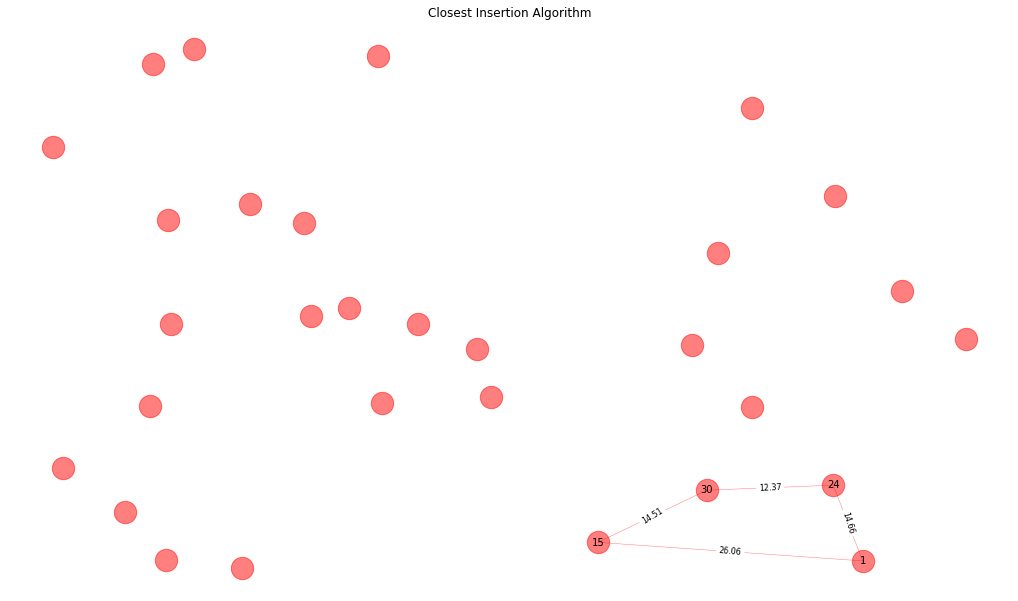

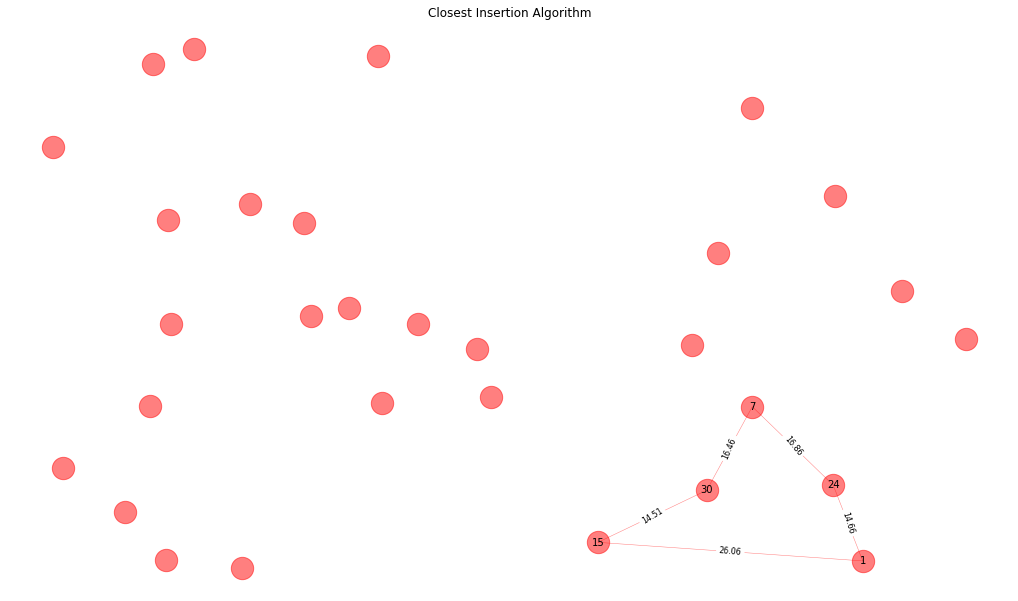

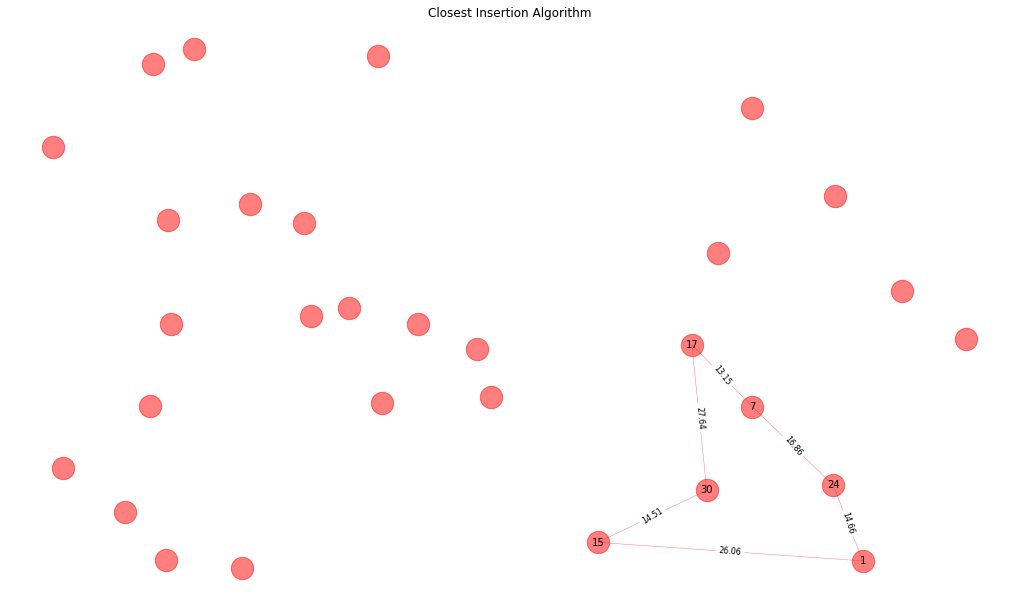

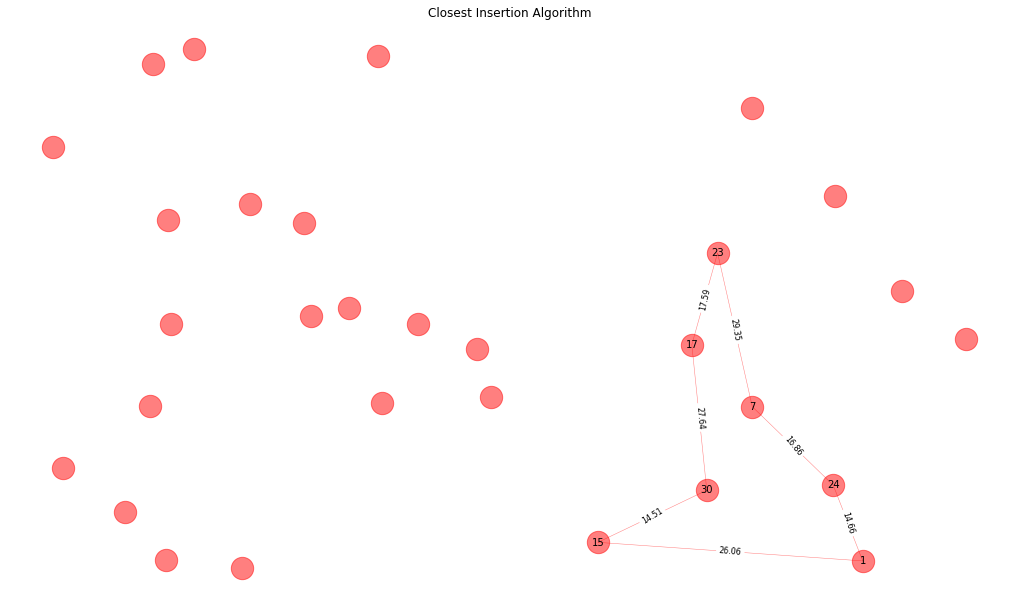

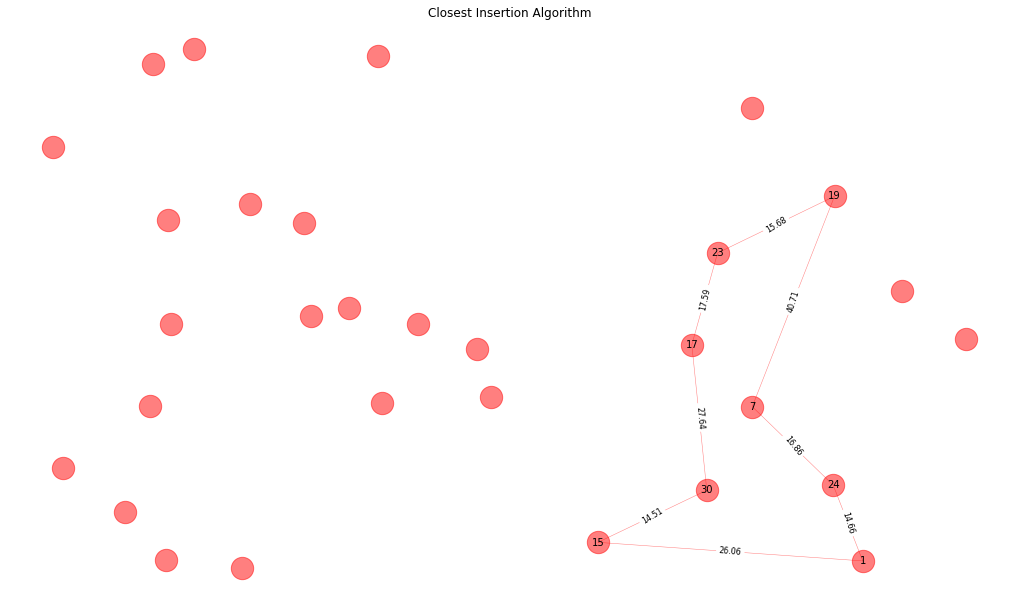

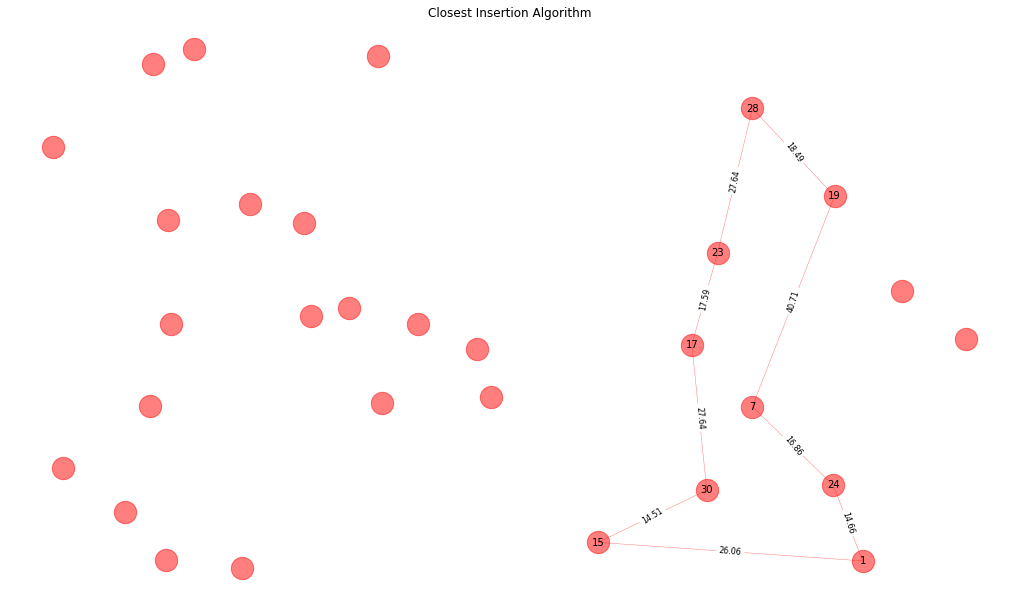

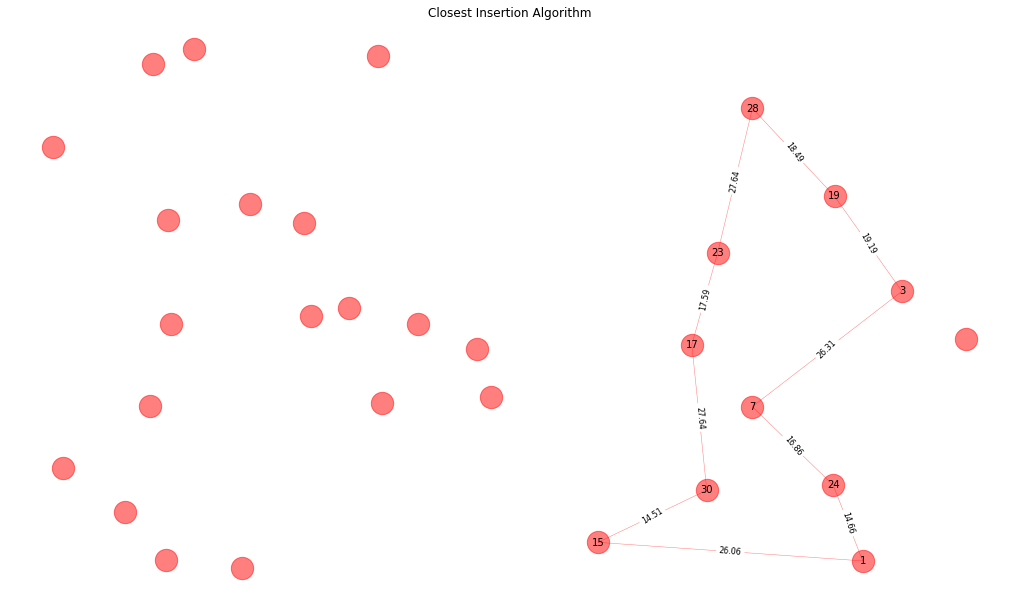

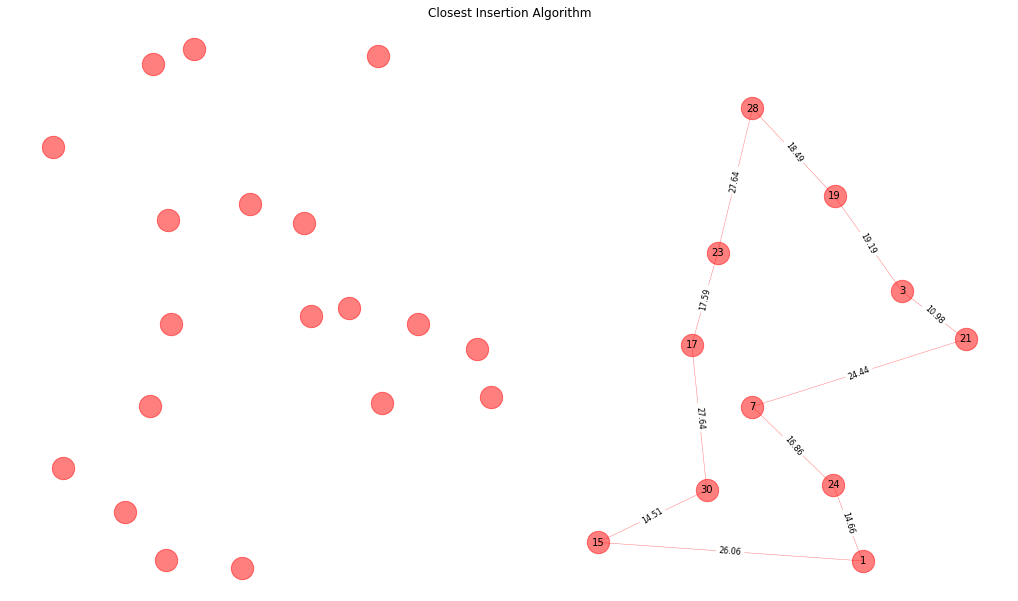

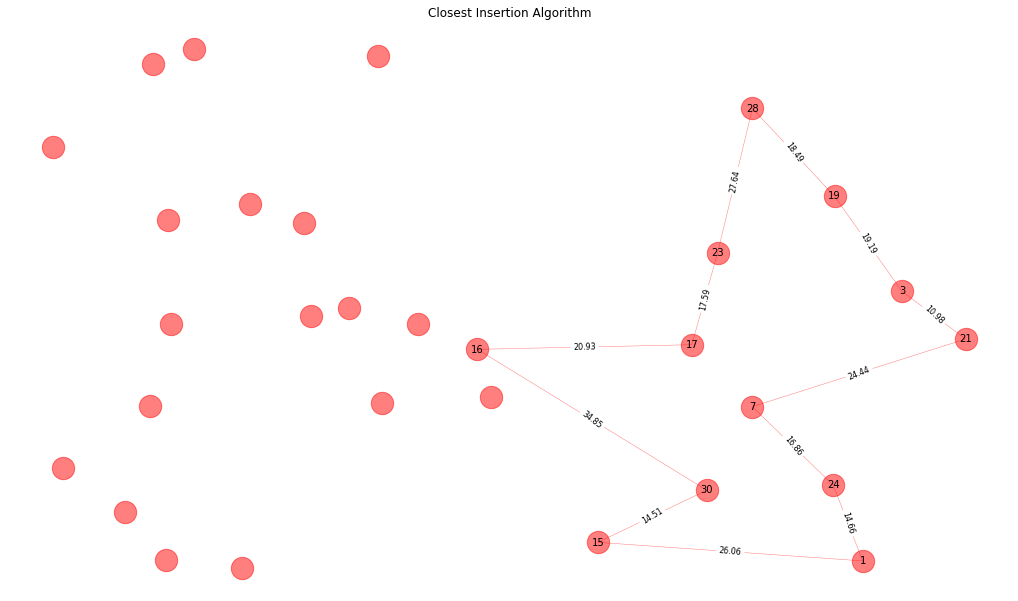

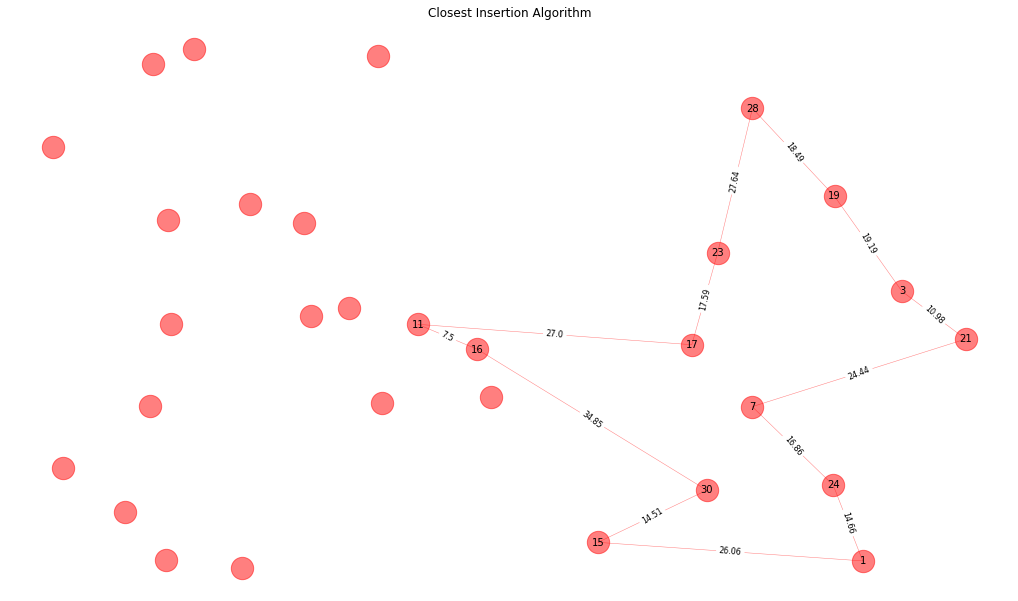

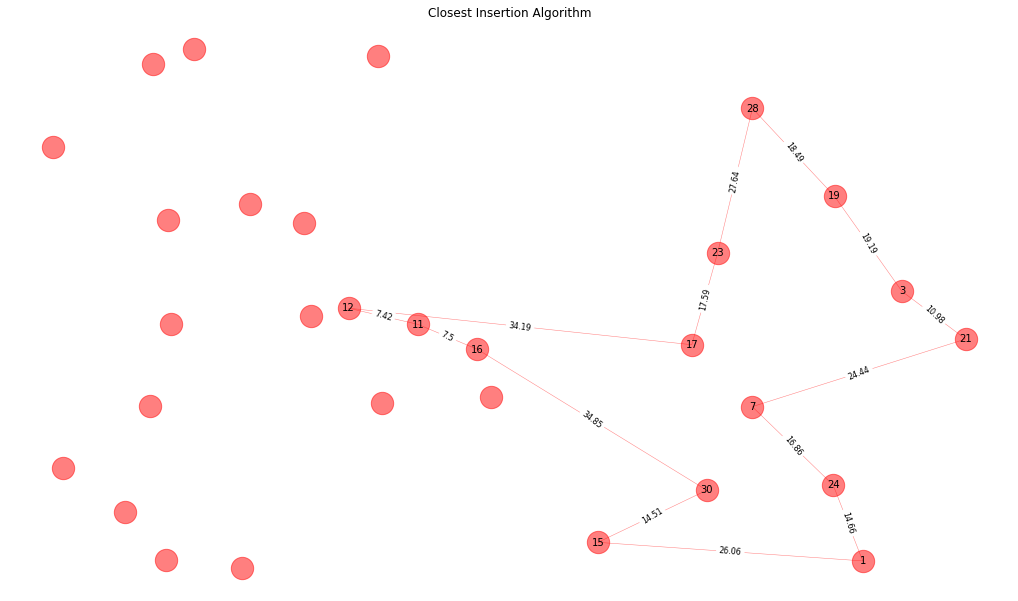

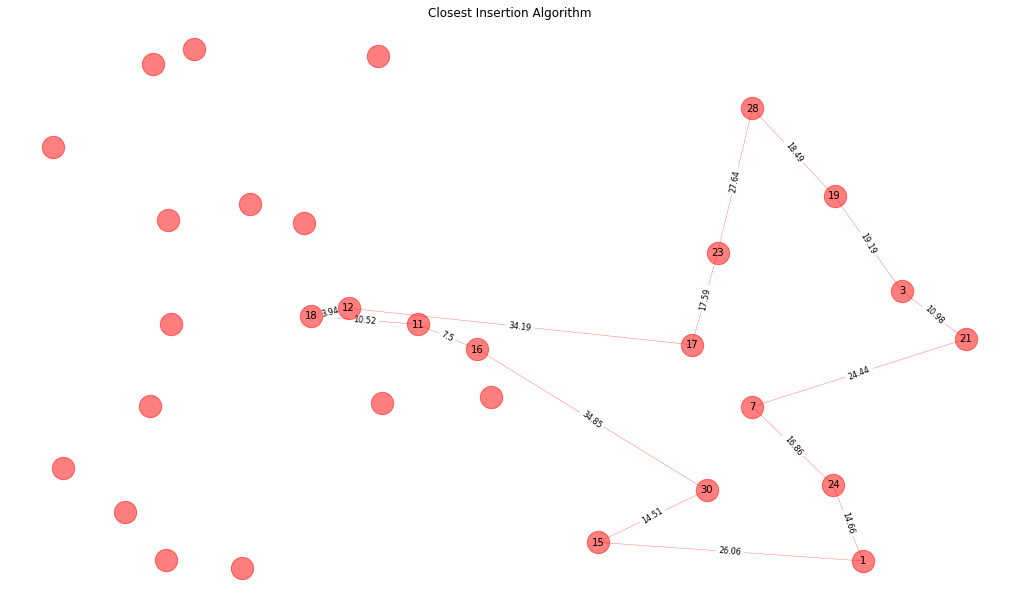

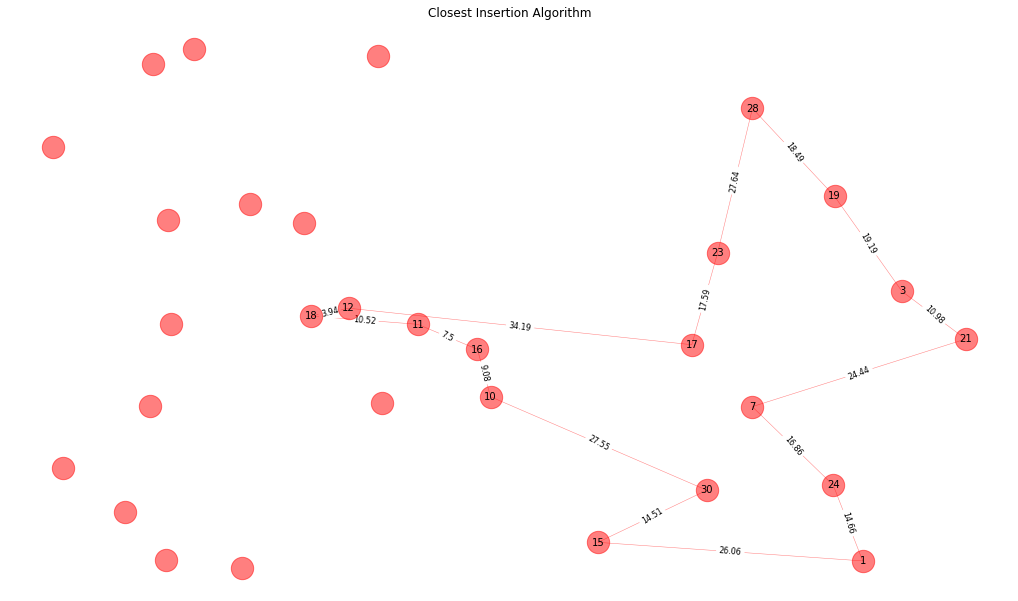

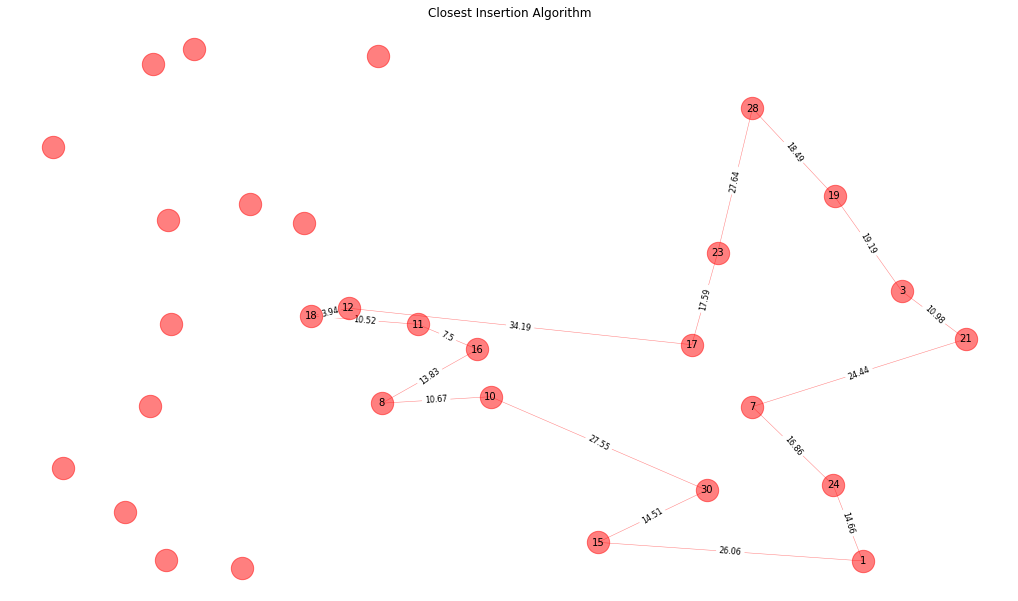

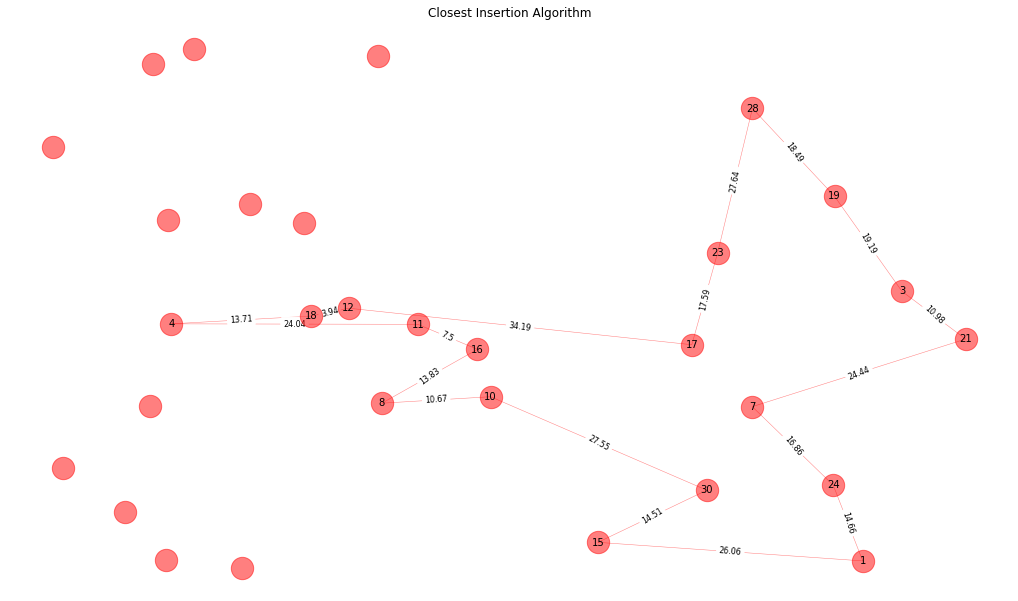

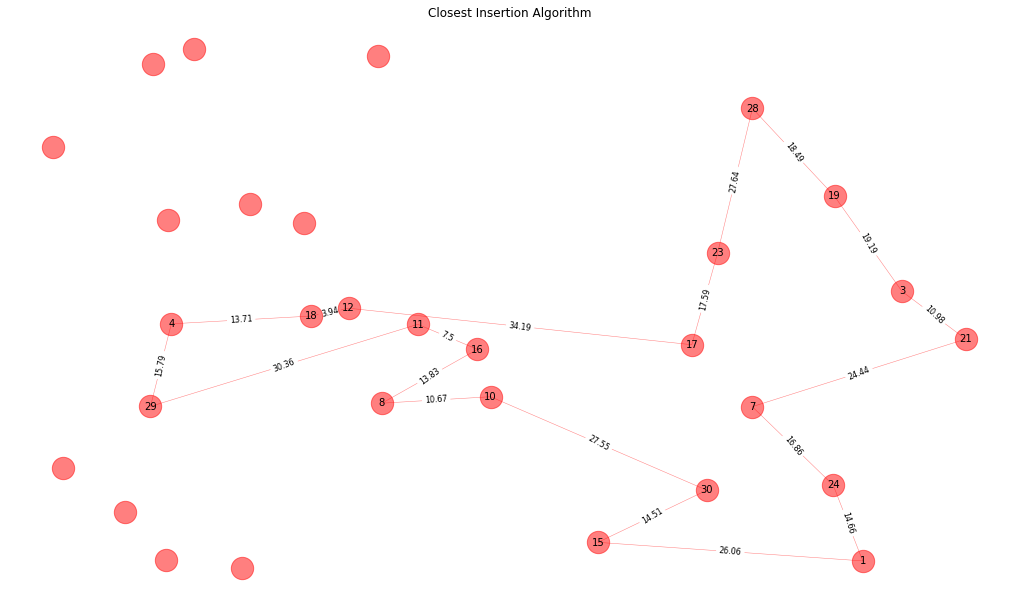

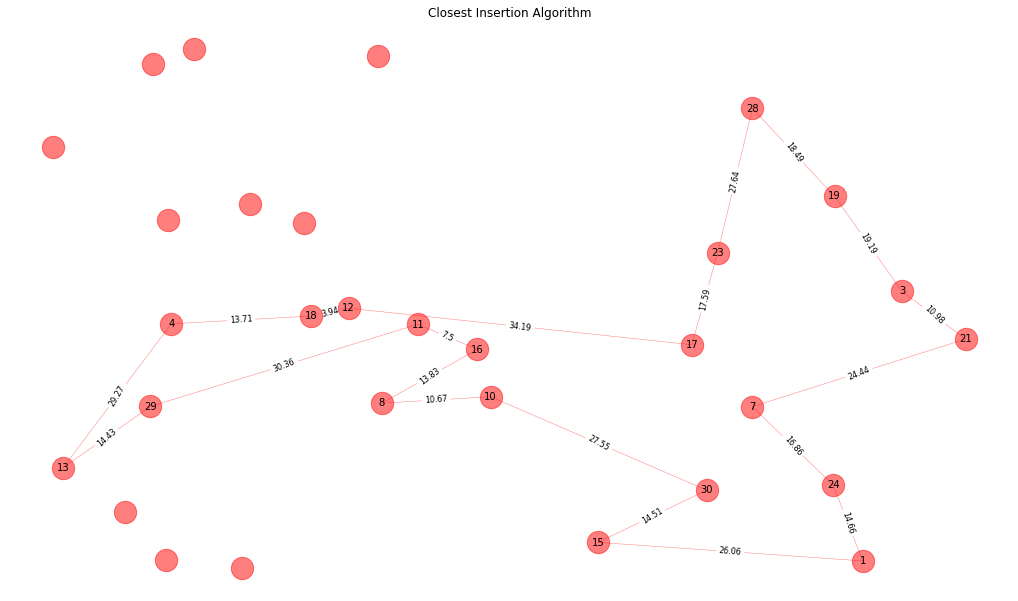

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fca11cb8a10> returned a result with an error set

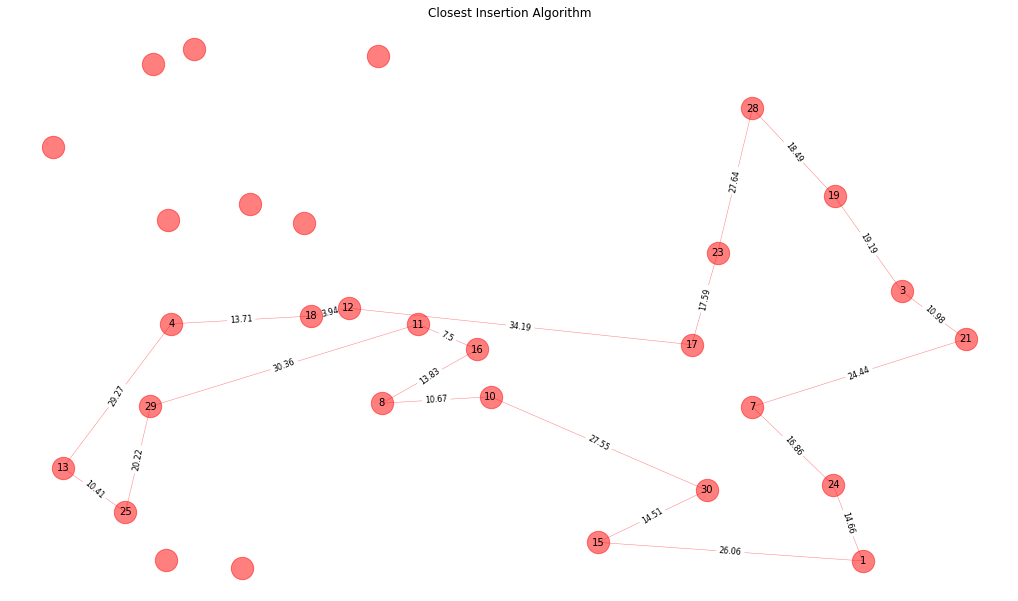

In [199]:
# Plot all paths in nearest insertion algorithm

for i in range(len(all_cycles[0])):
    graph.draw_closest_insertion( all_cycles[0][i], weights=True)
# Reset index for file name
graph.reset_file_index()

In [189]:
# Generate gif images from png plots

import os
import imageio

file_dir = 'nearest_insertion_algorithm.gif'
images_dir = 'graphs'
image_list = []

# Generate a list of absolute paths to the png images
filelist= sorted([os.path.abspath(f'{images_dir}/{file}') for file in os.listdir(images_dir) if file.endswith('.png')])
for file_name in filelist:
    image_list.append(imageio.imread(file_name))
    
# Create gif file 
kargs = { 'duration': 1 }
imageio.mimwrite(file_dir , image_list, **kargs)

![Nearest Insertion Algorithm Demo](nearest_insertion_algorithm.gif)

In [205]:
print(f'Graph size: {graph._size} nodes')
print(f'Total weight: {all_cycles[1]}')

Graph size: 40 nodes
Total weight: 629.79
